In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
# import tensorflow as tf

# tf.compat.v1.enable_eager_execution()

In [4]:
import tensorflow as tf
import malaya_speech

2022-06-15 22:11:06.673272: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/ubuntu/tf-nvidia/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from malaya_speech.train.model.vits import model
from malaya_speech.train.model import vits

In [6]:
hparams = vits.HParams(**malaya_speech.config.vits_base_config)
hparams

{'model': {'inter_channels': 192, 'hidden_channels': 192, 'filter_channels': 768, 'n_heads': 2, 'n_layers': 6, 'kernel_size': 3, 'p_dropout': 0.1, 'resblock': '1', 'resblock_kernel_sizes': [3, 7, 11], 'resblock_dilation_sizes': [[1, 3, 5], [1, 3, 5], [1, 3, 5]], 'upsample_rates': [8, 8, 2, 2], 'upsample_initial_channel': 512, 'upsample_kernel_sizes': [16, 16, 4, 4], 'n_layers_q': 3, 'use_spectral_norm': False}, 'train': {'log_interval': 200, 'eval_interval': 1000, 'seed': 1234, 'epochs': 20000, 'learning_rate': 0.0002, 'betas': [0.8, 0.99], 'eps': 1e-09, 'batch_size': 64, 'fp16_run': True, 'lr_decay': 0.999875, 'segment_size': 8192, 'init_lr_ratio': 1, 'warmup_epochs': 0, 'c_mel': 45, 'c_kl': 1.0}, 'data': {'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 0.0, 'mel_fmax': None, 'add_blank': True, 'n_speakers': 0}}

In [7]:
spec_channels = hparams.data.filter_length // 2 + 1
segment_size = hparams.train.segment_size // hparams.data.hop_length
spec_channels, segment_size

(513, 32)

In [8]:
import json
import os
from glob import glob

with open('../speech/imda/output.json') as fopen:
    data = json.load(fopen)
    
wavs = glob('../speech/imda/*.WAV')

In [9]:
vocab = malaya_speech.utils.text.TTS_SYMBOLS

batch = []
for w in wavs:
    t = data[os.path.split(w)[1]]
    y, _ = malaya_speech.load(w)
    batch.append((y, malaya_speech.utils.text.tts_encode(t, vocab)))

In [10]:
from librosa.filters import mel as librosa_mel_fn

melbank = librosa_mel_fn(hparams.data.sampling_rate, hparams.data.filter_length, 
                          hparams.data.n_mel_channels,hparams.data.mel_fmin, hparams.data.mel_fmax)

MEL = tf.convert_to_tensor(melbank)

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return tf.log(tf.clip_by_value(x, clip_val, tf.reduce_max(x)) * C)


def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return tf.exp(x) / C


def spectral_normalize(magnitudes):
    output = dynamic_range_compression(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression(magnitudes)
    return output

def spectrogram_tf(audio_norm, filter_length, hop_length):
    p = int((filter_length-hop_length)/2)
    padded = tf.pad(audio_norm, [[p, p]], mode ='reflect')
    spec = tf.abs(tf.signal.stft(
        padded,
        filter_length,
        hop_length,
        fft_length=None,
        window_fn=tf.signal.hann_window,
        pad_end=False,
    ))
    spec = tf.sqrt(spec ** 2 + 1e-6)
    return spec

def spec_to_mel(spec):
    spec = tf.matmul(spec, tf.transpose(MEL))
    spec = spectral_normalize(spec)
    return spec

/tmp/ipykernel_2369453/600007807.py:3: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=None as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melbank = librosa_mel_fn(hparams.data.sampling_rate, hparams.data.filter_length,


In [11]:
X = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'X_placeholder')
X_len = tf.compat.v1.placeholder(tf.int32, [None], name = 'X_len_placeholder')

In [12]:
batch_size = tf.shape(X)[0]
features = tf.TensorArray(dtype = tf.float32, size = batch_size, dynamic_size = True, infer_shape = False)
features_len = tf.TensorArray(dtype = tf.int32, size = batch_size)

init_state = (0, features, features_len)

def condition(i, features, features_len):
    return i < batch_size

def body(i, features, features_len):
    f = spectrogram_tf(X[i, :X_len[i]], hparams.data.filter_length, hparams.data.hop_length)
    f_len = tf.shape(f)[0]
    return i + 1, features.write(i, f), features_len.write(i, f_len)

_, features, features_len = tf.while_loop(condition, body, init_state)
features_len = features_len.stack()

padded_features_mel = tf.TensorArray(dtype = tf.float32, size = batch_size)
padded_features = tf.TensorArray(dtype = tf.float32, size = batch_size)
padded_lens = tf.TensorArray(dtype = tf.int32, size = batch_size)
maxlen = tf.reduce_max(features_len)

init_state = (0, padded_features_mel, padded_features, padded_lens)

def condition(i, padded_features_mel, padded_features, padded_lens):
    return i < batch_size

def body(i, padded_features_mel, padded_features, padded_lens):
    f = features.read(i)
    f_mel = spec_to_mel(f)
    len_f = tf.shape(f)[0]
    f = tf.pad(f, [[0, maxlen - tf.shape(f)[0]], [0,0]])
    f_mel = tf.pad(f_mel, [[0, maxlen - tf.shape(f)[0]], [0,0]])
    return i + 1, padded_features_mel.write(i, f), padded_features.write(i, f), padded_lens.write(i, len_f)

_, padded_features_mel, padded_features, padded_lens = tf.while_loop(condition, body, init_state)
padded_features_mel = padded_features_mel.stack()
padded_features = padded_features.stack()
padded_lens = padded_lens.stack()
padded_lens.set_shape((None,))
padded_features_mel.set_shape((None, None, hparams.data.n_mel_channels))
padded_features.set_shape((None, None, spec_channels))
padded_features, padded_lens

(<tf.Tensor 'TensorArrayStack_2/TensorArrayGatherV3:0' shape=(?, ?, 513) dtype=float32>,
 <tf.Tensor 'TensorArrayStack_3/TensorArrayGatherV3:0' shape=(?,) dtype=int32>)

In [13]:
batch_x, batch_y = [b[0] for b in batch], [b[1] for b in batch]
x, x_len = malaya_speech.utils.padding.sequence_1d(batch_x, return_len = True)

In [14]:
y, y_len = malaya_speech.utils.padding.sequence_1d(batch_y, return_len = True)

In [15]:
# sess = tf.Session()
# o = sess.run([padded_features, padded_lens], feed_dict = {X: x, X_len: x_len})

In [16]:
model = vits.Model(len(vocab), spec_channels, segment_size, **hparams.model)

In [17]:
# x = tf.constant([[1,2,3,4,5], [2,3,0,0,0]])
# x_lengths = tf.constant([5, 2])
# y = tf.random.normal(shape = (2, 100, spec_channels))
# y_lengths = tf.constant([50, 100])

In [18]:
T = tf.placeholder(tf.int32, [None, None])
T_lengths = tf.placeholder(tf.int32, [None])

In [19]:
y_hat, l_length, attn, ids_slice, x_mask, z_mask,\
      (z, z_p, m_p, logs_p, m_q, logs_q) = model(T, T_lengths, padded_features, padded_lens)

In [20]:
outputs = model.infer(T, T_lengths)
outputs

(<tf.Tensor 'generator/Tanh:0' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'transpose:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'ExpandDims:0' shape=(?, ?, 1) dtype=float32>,
 (<tf.Tensor 'residual_coupling_block/residual_coupling_layer/concat:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'add:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'MatMul:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'MatMul_1:0' shape=(?, ?, 192) dtype=float32>))

In [21]:
outputs[:2]

(<tf.Tensor 'generator/Tanh:0' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'transpose:0' shape=(?, ?, ?) dtype=float32>)

In [22]:
from malaya_speech.train.model.vits import commons

In [23]:
def kl_loss(z_p, logs_q, m_p, logs_p, z_mask):
    kl = logs_p - logs_q - 0.5
    kl += 0.5 * ((z_p - m_p)**2) * tf.exp(-2. * logs_p)
    kl = tf.reduce_sum(kl * z_mask)
    l = kl / tf.reduce_sum(z_mask)
    return l

loss_kl = kl_loss(z_p, logs_q, m_p, logs_p, z_mask) * hparams.train.c_kl

In [24]:
y_hat_mel = tf.TensorArray(dtype = tf.float32, size = batch_size)
init_state = (0, y_hat_mel)

def condition1(i, y_hat_mel):
    return i < batch_size

def body1(i, y_hat_mel):
    f = spectrogram_tf(y_hat[i,:,0], hparams.data.filter_length, hparams.data.hop_length)
    f = spec_to_mel(f)
    return i + 1, y_hat_mel.write(i, f)

_, y_hat_mel = tf.while_loop(condition1, body1, init_state)
y_hat_mel = y_hat_mel.stack()
y_hat_mel.set_shape((None, None, hparams.data.n_mel_channels))

In [25]:
y_hat_mel_out = tf.TensorArray(dtype = tf.float32, size = batch_size)
init_state = (0, y_hat_mel_out)

def condition2(i, y_hat_mel_out):
    return i < batch_size

def body2(i, y_hat_mel_out):
    f = spectrogram_tf(outputs[0][i,:,0], hparams.data.filter_length, hparams.data.hop_length)
    f = spec_to_mel(f)
    return i + 1, y_hat_mel_out.write(i, f)

_, y_hat_mel_out = tf.while_loop(condition2, body2, init_state)
y_hat_mel_out = y_hat_mel_out.stack()
y_hat_mel_out.set_shape((None, None, hparams.data.n_mel_channels))

In [26]:
from malaya_speech.train.model.vits import commons

mel = tf.matmul(padded_features, tf.transpose(MEL))
mel = spectral_normalize(mel)
y_mel = commons.slice_segments(mel, ids_slice, hparams.train.segment_size // hparams.data.hop_length)

In [27]:
mae = tf.losses.absolute_difference

In [28]:
loss_mel = mae(labels=y_mel, predictions=y_hat_mel) * hparams.train.c_mel
loss_mel

<tf.Tensor 'mul_23:0' shape=() dtype=float32>

In [29]:
loss_dur = l_length
loss = loss_kl + loss_dur + loss_mel

In [30]:
optimizer = malaya_speech.train.optimizer.adamw.create_optimizer(loss, 1e-5, 10000, 1000)

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

2022-06-15 22:11:44.259292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-15 22:11:44.262451: E tensorflow/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-15 22:11:44.262479: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: huseincomel-desktop
2022-06-15 22:11:44.262482: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: huseincomel-desktop
2022-06-15 22:11:44.262526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-15 22:11:44.262539: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-06-15 22:11:44.262542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-06-15 22:11:44.267883: I tensorflow/

In [32]:
o_ = sess.run(outputs[:2], feed_dict = {T: y, T_lengths: y_len})
o_[0].shape, o_[1].shape

((3, 29696, 1), (3, 116, 61))

In [33]:
for i in range(200):
    print(i, sess.run([loss_kl, loss_dur, loss_mel, optimizer], feed_dict = {X: x,
                                                        X_len: x_len,
                                                        T: y,
                                                        T_lengths: y_len}))

0 [54879.64, 1.1684176, 165.708, None]
1 [63708.83, 0.87463075, 113.67004, None]
2 [50327.45, 0.95359427, 142.62148, None]
3 [44280.06, 0.87001055, 155.70029, None]
4 [63344.25, 0.7992706, 137.60237, None]
5 [43071.195, 0.94516295, 157.69347, None]
6 [39847.48, 1.0657405, 136.18271, None]
7 [53038.793, 0.9800213, 155.59663, None]
8 [41942.49, 0.89352185, 126.77022, None]
9 [41383.293, 0.98052526, 116.637245, None]
10 [30262.682, 0.81755275, 130.78677, None]
11 [28330.932, 1.0238682, 139.86412, None]
12 [28552.574, 1.2722737, 126.187546, None]
13 [30423.781, 0.91717005, 136.1277, None]
14 [23208.037, 0.9532619, 116.57939, None]
15 [22819.7, 1.0360976, 131.49968, None]
16 [19251.152, 0.89921284, 159.70636, None]
17 [26618.148, 0.9154551, 130.94423, None]
18 [16087.048, 0.78927064, 117.4824, None]
19 [16173.033, 0.8486058, 129.28654, None]
20 [15841.293, 1.0274545, 139.21085, None]
21 [13503.914, 1.0465486, 153.11234, None]
22 [13284.572, 1.0377135, 145.67114, None]
23 [11536.873, 0.91798

In [34]:
o_ = sess.run([y_mel, y_hat_mel, outputs[1], y_hat_mel_out], feed_dict = {X: x,
                                                        X_len: x_len,
                                                        T: y,
                                                        T_lengths: y_len})
o_[0].shape, o_[1].shape

((3, 32, 80), (3, 32, 80))

In [35]:
o_[2].shape, o_[3].shape

((3, 299, 61), (3, 299, 80))

In [36]:
import matplotlib.pyplot as plt

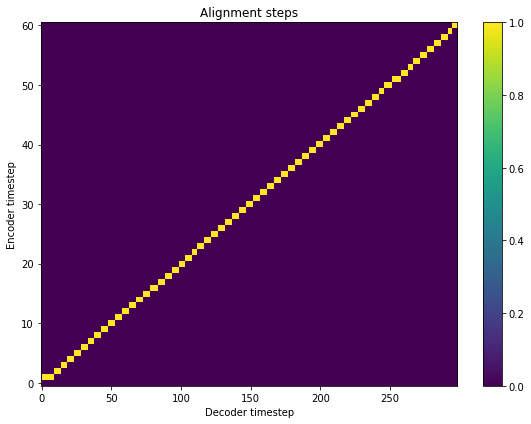

In [42]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o_[-2][1].T,
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [43]:
import numpy as np

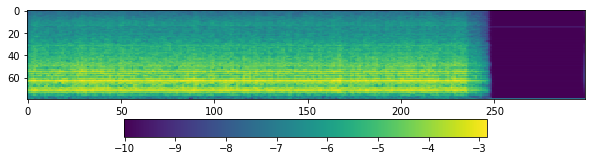

In [44]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(o_[3][0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

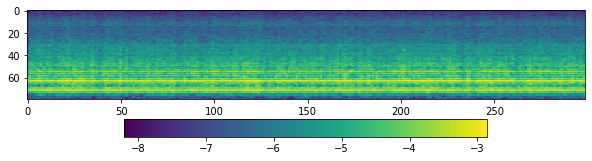

In [45]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(o_[3][1]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

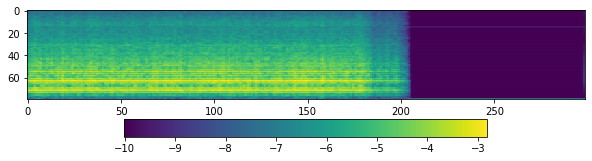

In [46]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(o_[3][2]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()